In [1]:
# importamos las librería
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

Python: 3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]
scipy: 1.7.0
numpy: 1.21.1
matplotlib: 3.4.2


In [2]:
# Leer la documentación de SQLALCHEMY
import sqlalchemy

In [3]:
!pip install psycopg2-binary

In [4]:
# Leer la documentación de PSYCOPG2
import psycopg2

In [5]:
## DB
from sqlalchemy import create_engine
import psycopg2

## data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

## visualization
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Warnings and other tools
import itertools
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Cargamos las credenciales de la base de datos

# Connect to an existing database HEROKU _ vuestro nombre
conn = psycopg2.connect(
    host="ec2-54-194-147-61.eu-west-1.compute.amazonaws.com",
    database="d22osf7e20andg",
    user="yvwjtfdsifkkcu",
    password="b1c54c858cf14845b74657662ec210fe687f9927c8adfb40ab24e9ea14f5509c",
    port=5432)



In [7]:
# Cargamos en pandas la query anterior o consulta de una tabla (TABLE) o cargamos unas vistas (VIEW)

query = """
SELECT * 
FROM "DATACHALLENGE".orders_detailed ;
"""

# Obtenemos un dataframe

df = pd.read_sql(query, conn)


# EDA

In [214]:
# Vemos el tamaño del dataframe 
df.shape

(30288, 10)

In [9]:
# Vemos los tipos de datos del dataframe

df.dtypes

industry_name                     object
uuid                              object
merchant_uuid                     object
created                   datetime64[ns]
country                           object
annual_percentage_rate           float64
number_instalments                 int64
booking                          float64
dtype: object

In [215]:
# Vemos que no haya nulos en el dataframe


df.isnull().sum()

industry_name             0
uuid                      0
merchant_uuid             0
created                   0
country                   0
annual_percentage_rate    0
number_instalments        0
booking                   0
month                     0
vertical                  0
dtype: int64

In [11]:
# Vemos que no haya duplicados en el dataframe

df.duplicated().sum()

0

In [12]:
# Vemos la descripcion estadistica de las variables cuantitativas del dataframe

df.describe()

,annual_percentage_rate,number_instalments,booking
count,30288.000000,30288.000000,30288.000000
mean,18.003554,6.751651,306.476432
std,10.383416,3.927623,368.792923
min,-0.000255,0.000000,0.530000
25%,20.000000,4.000000,97.215000
50%,24.500000,6.000000,185.935000
75%,24.500000,12.000000,364.937500
max,315.949970,24.000000,3000.000000


In [216]:
# Vemos si hay alguna correlacion entre las principales variables

df.corr()

,annual_percentage_rate,number_instalments,booking,month
annual_percentage_rate,1.000000,-0.135725,-0.242535,-0.124927
number_instalments,-0.135725,1.000000,0.417031,0.037980
booking,-0.242535,0.417031,1.000000,0.044056
month,-0.124927,0.037980,0.044056,1.000000


In [14]:
# Extraemos el mes del datatime para ver la seasonality

df['month'] = pd.DatetimeIndex(df['created']).month

In [86]:
# Agrupamos el campo industry_name en un campo de business margin para analizar cada sector 


df['vertical'] = np.where(df['industry_name'].str.contains(r'|'.join(['Travel', 'Viajes'])), 'Travel', 
                 np.where(df['industry_name'].str.contains(r'|'.join(['Fashion', 'Jewelry', 'Beauty', 'Belleza', 'Moda', 'Joyería'])), 'Retail Fashion',
                 np.where(df['industry_name'].str.contains(r'|'.join(['Sports', 'Deportes', 'Deportivas'])), 'Retail Sports',
                 np.where(df['industry_name'].str.contains(r'|'.join(['Hogar', 'Home', 'Electrodomésticos'])), 'Retail Home',
                 np.where(df['industry_name'].str.contains(r'|'.join(['Computing', 'Informatica'])), 'Retail Electronics',
                 np.where(df['industry_name'].str.contains(r'|'.join(['Education', 'Educación ',  'Profesionales', 'Services'])), 'Education',
                    'Retail other'))))))

In [87]:
# Chequeamos las verticales finales

df.vertical.unique()

array(['Travel', 'Retail Electronics', 'Retail Sports', 'Retail Home',
       'Retail other', 'Retail Fashion', 'Education'], dtype=object)

<AxesSubplot:xlabel='month', ylabel='booking'>

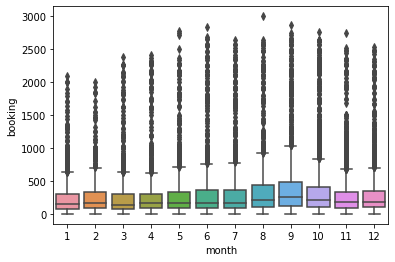

In [217]:
#Seasonality analysis

#Determinamos si hay un pico o valle en la cantidad de prestamos para determinar un cash need o pico de ventas durante el año

sns.boxplot(x=df.month, y=df.booking, data=df)

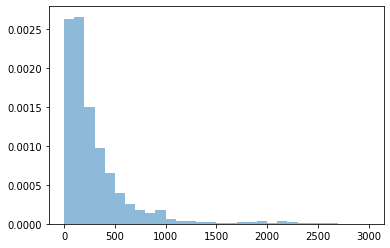

In [92]:
# Hacemos un histograma sobre las principales variables para determinar su forma
# Aqui vemos como la mayoria de prestamos que se otorgan son menores a 300 euros

plt.hist(df.booking, bins=30, density=1, alpha=0.5)
plt.show()

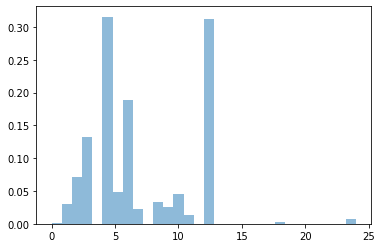

In [93]:
# Al analizar la distribucion de instalments, vemos que la empresa otorga prestamos principalmente en 4 y 12 instalments

plt.hist(df.number_instalments, bins=30, density=1, alpha=0.5)
plt.show()

In [94]:
#Detectamos 2 grandes outliers en el calculo del APR, los cuales seran removidos para mejor visualizacion

q = df["annual_percentage_rate"].quantile(0.999)

df2 = df[df["annual_percentage_rate"] < q]

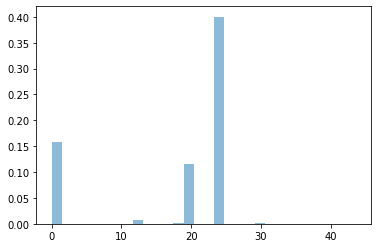

In [219]:
# El APR que mas veces sucede en la empresa es de aproximadamente 24%, como también hay muchas ordenes sin margen

plt.hist(df2.annual_percentage_rate, bins=30, density=1, alpha=0.5)
plt.show()

<AxesSubplot:xlabel='booking', ylabel='annual_percentage_rate'>

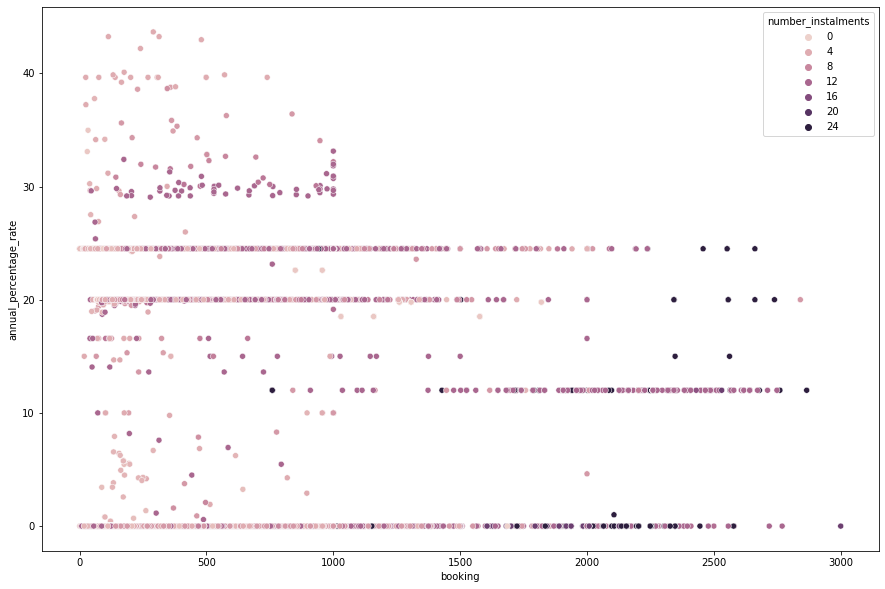

In [97]:
# Al analizar el conjunto de ordenes, vemos que a mayor booking, mayor numero de cuotas
# como tambien detectamos que hay un cap del APR en 25% para prestamos mayores a 1000 euros.

fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x=df2.booking, y=df2.annual_percentage_rate, hue=df2.number_instalments, data=df2)


<AxesSubplot:xlabel='booking', ylabel='number_instalments'>

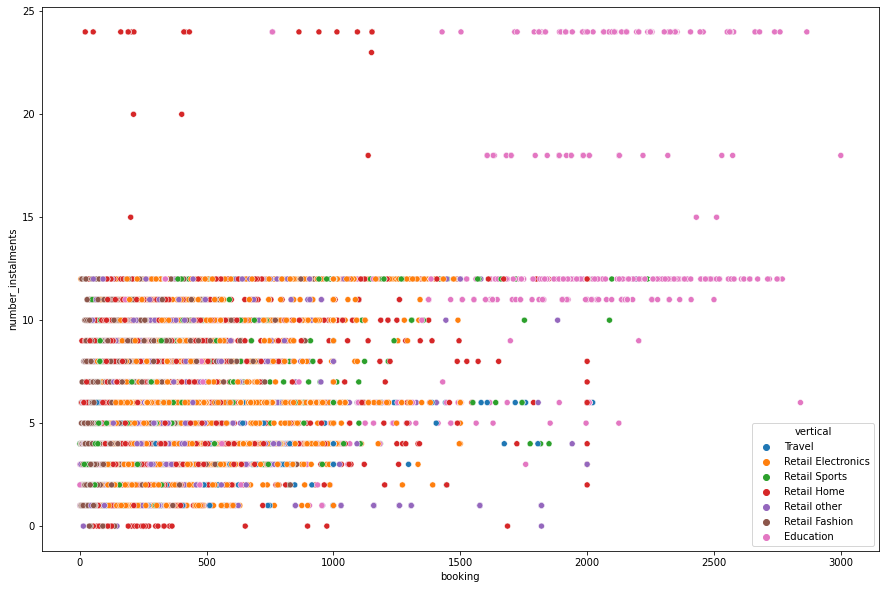

In [221]:
# Al analizar el conjunto de ordenes, vemos que a mayor booking, mayor numero de cuotas
# como tambien detectamos que hay un cap del APR en 25% para prestamos mayores a 1000 euros.

fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x=df2.booking, y=df2.number_instalments, hue=df2.vertical, data=df2)

                                 OLS Regression Results                                
Dep. Variable:     number_instalments   R-squared (uncentered):                   0.509
Model:                            OLS   Adj. R-squared (uncentered):              0.509
Method:                 Least Squares   F-statistic:                          3.142e+04
Date:                Sun, 27 Feb 2022   Prob (F-statistic):                        0.00
Time:                        19:44:41   Log-Likelihood:                         -94364.
No. Observations:               30257   AIC:                                  1.887e+05
Df Residuals:                   30256   BIC:                                  1.887e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<AxesSubplot:xlabel='booking', ylabel='number_instalments'>

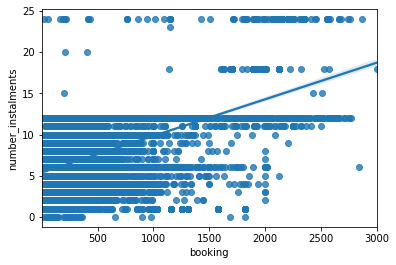

In [98]:
# aplicando una regresion lineal entre los prestamos y el numero de cuotas, no llegamos a concluir que existe una fuerte correlacion,

import statsmodels.api as sm

X = df2[['booking']]
Y = df2[['number_instalments']]
X=X.astype(float)
Y=Y.astype(float)
model = sm.OLS(Y,X).fit()
print(model.summary())

sns.regplot(x='booking', y='number_instalments', data=df2)


In [127]:
# Si realizamos un analisis geografico, vemos que esta empresa solo opera en Spain

df2.country.unique()

array(['Spain'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='vertical'>

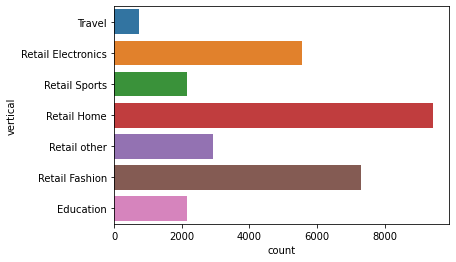

In [213]:
# A nivel de verticales, la distribucion de cantidad de prestamos, los cuales se concentran en:
# en retail fashion, retail home, retail electronics


sns.countplot(y=df2.vertical, data=df2)

1 plotting booking 
2 plotting number_instalments 
3 plotting annual_percentage_rate 


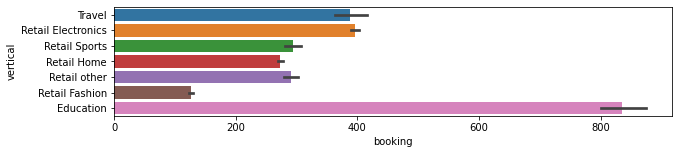

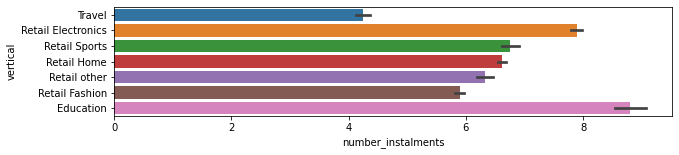

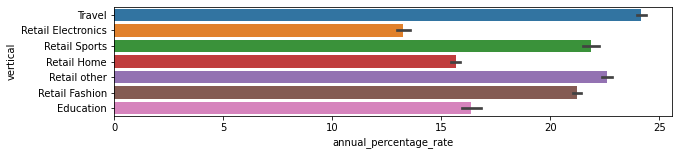

In [193]:
# A nivel de verticales, vemos como education tiene los prestamos mas grandes y de mayor cantidad de cuotas, 
# y no es la mas rentable en revenue, 
# seguramente haya problemas al evaluar la rentabilidad dado el mayor coste de esta vertical

# la vertical travel, si bien no tiene tanto peso en el portafolio, es la linea mas rentable

# las verticales de retail tienen diversas caracteristicas, 
# en general son de duraciones cortas, prestamos pequenos, y rentabilidades altas
# lo que en rentabilidad se traduce como alta rotacion y alto profit dado el volumen de negocio

a = ['booking', 'number_instalments', 'annual_percentage_rate']

for i, feature in enumerate(a):
    plt.figure(figsize=(10,2))  # forces a new figure
    sns.barplot(data=df2, x=feature, y=df2.vertical)
    print("{} plotting {} ".format(i+1,feature))

In [227]:
# solo para visulizar el fee promedio y el fee promedio mensual, lo determinamos matematicamente


df2['fees'] = ((df2['annual_percentage_rate']/100) / 365) * df2['booking'] * df2['number_instalments'] * 30
df2['monthly_fees'] = df2['fees'] / df2['number_instalments']

df3 = df2.groupby(df2.vertical).mean().reset_index()

df3

,vertical,annual_percentage_rate,number_instalments,booking,month,fees,monthly_fees
0,Education,16.377711,8.800466,835.385049,7.129604,67.969492,6.666126
1,Retail Electronics,13.271017,7.888209,396.244482,9.278668,34.296335,3.906567
2,Retail Fashion,21.239680,5.896122,126.849651,7.912704,13.837279,2.018408
3,Retail Home,15.664796,6.619346,273.305737,7.055107,23.512247,3.234781
4,Retail Sports,21.879810,6.758891,294.041165,6.908083,45.945033,5.404993
5,Retail other,22.607643,6.322878,291.492333,7.963178,36.058608,5.174662
6,Travel,24.170699,4.241935,388.560349,6.637097,34.694639,7.610458


<AxesSubplot:xlabel='monthly_fees', ylabel='vertical'>

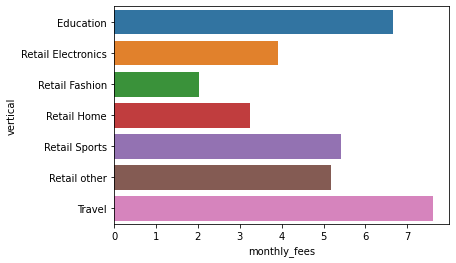

In [228]:
# aqui vemos como educacion tiene un fee alto dado su margen de negocio,
# travel tiene un fee mas alto que retail
# tambien vemos como retail fashion es el que soporta menos fees, dada su estructura de costes y margenes.

sns.barplot(x=df3.monthly_fees, y=df3.vertical, data=df3)

<AxesSubplot:xlabel='vertical', ylabel='monthly_fees'>

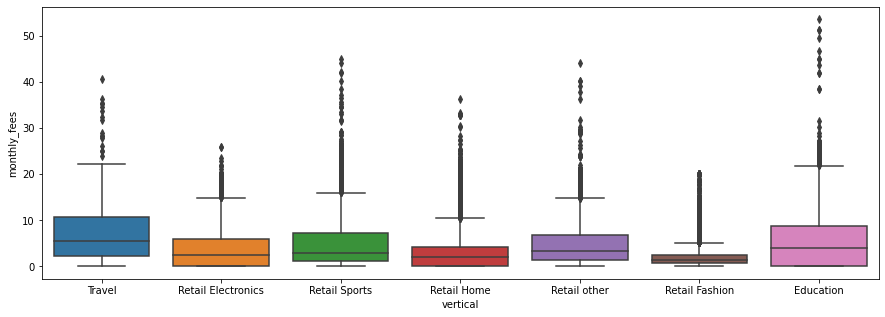

In [233]:
# Analizamos la distribucion estadistica de cada vertical por fee mensual

fig = plt.figure(figsize=(15, 5))
sns.boxplot(x=df2.vertical, y=df2.monthly_fees, data=df2)

<AxesSubplot:xlabel='booking', ylabel='number_instalments'>

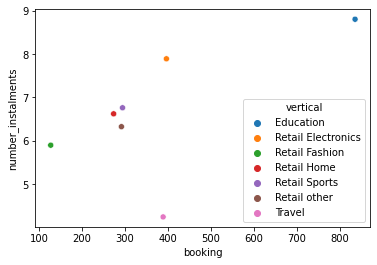

In [234]:
# finalmente, a modo de insights, hacemos un plot para determinar las caracteristicas conjuntas de cada vertical
# donde quedan claramente separada cada vertical

sns.scatterplot(x=df3.booking, y=df3.number_instalments, hue=df3.vertical, data=df3)


<AxesSubplot:xlabel='booking', ylabel='annual_percentage_rate'>

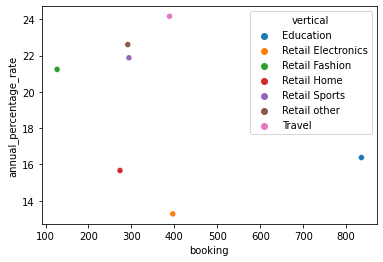

In [235]:
# finalmente, a modo de insights, hacemos un plot para determinar las caracteristicas conjuntas de cada vertical
# donde quedan claramente separada cada vertical ahora por APR

sns.scatterplot(x=df3.booking, y=df3.annual_percentage_rate, hue=df3.vertical, data=df3)


In [141]:
# INSIGHTS

In [25]:
# Conclusiones

In [26]:
# Inferir datos con otras fuentes externas con API's

In [27]:
# Pueden mostrar los datos en Power BI Desktop (free) / Tableau PRO (de pago)

In [28]:
# Seguir las tareas restantes para paquetizar el trabajo anterior.

# En caso de crear funciones utilizamos bien try...except...finally (pass)
def nombre_funcion():
  try:
    (cond)
    print("Función ejecutada estado 200")
  except Exception as e:
    e
    print("Ha fallado")
  finally:
    print("otra condición final---- ejecutar otra tarea/función")

In [29]:
# en caso de utilizar logging
import logging

logger = logging.getLogger()
logger.info
logger.warnings
logger.alerts

AttributeError: 'RootLogger' object has no attribute 'warnings'